## overturning circulation in temp

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34749 Dashboard: /proxy/42553/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
expt = '1deg_jra55_ryf_RCPcont'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2900-01-31'
end_time = '2910-01-01'

In [27]:
psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = psisubmeso.sum('grid_xt_ocean')

else:
    GM = False

In [29]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)

In [90]:
psi_avg_cont = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_cont = psi_avg_cont + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_cont.load()

<xarray.DataArray (neutral: 74, grid_yu_ocean: 300)>
array([[ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  3.4108356e-01,  2.9121554e-01, ...,
        -1.7166778e-01, -7.2749920e-02, -7.7586961e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75

note doesn't do correct zonal averaging north of 65N

In [166]:
SST_max = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15

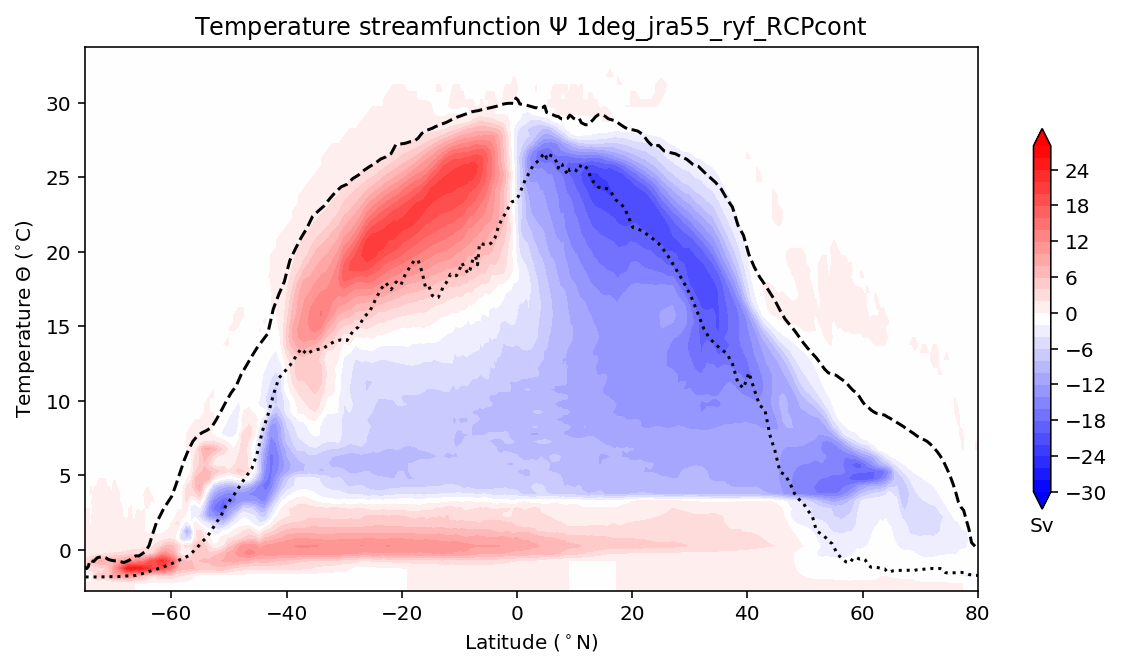

In [207]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-30,30,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap='bwr', levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')

cb.ax.set_xlabel('Sv')
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Temperature streamfunction $\Psi$ %s' % expt);
#plt.savefig('figures/overturning')

Now calculate internal heat function  $\mathcal{A}_I(\phi, \Theta, t)=\rho_0C_p \int_{-\infty }^{\Theta} \Psi d\Theta ' + \mathcal{A}_D$?

rho_0*c_p*psi_avg_cont.cumsum('neutral')

Need to also mask out where sea surface stops so we don't cumsum over air

In [191]:
SST_max2 = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_max2.coords['yt_ocean'] = A_I.grid_yu_ocean.values
SST_max2 = SST_max2.rename({'yt_ocean':'grid_yu_ocean'})
SST_mean = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).mean('time').mean('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_mean.coords['yt_ocean'] = A_I.grid_yu_ocean.values
SST_mean = SST_mean.rename({'yt_ocean':'grid_yu_ocean'})

In [183]:
rho_0 = 1030#kg/m^3
c_p = 3992 
A_I = -rho_0*c_p*psi_avg_cont.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I = A_I/10**9 # convert to PW
A_I = A_I.where(A_I.neutral < SST_max2).fillna(0)

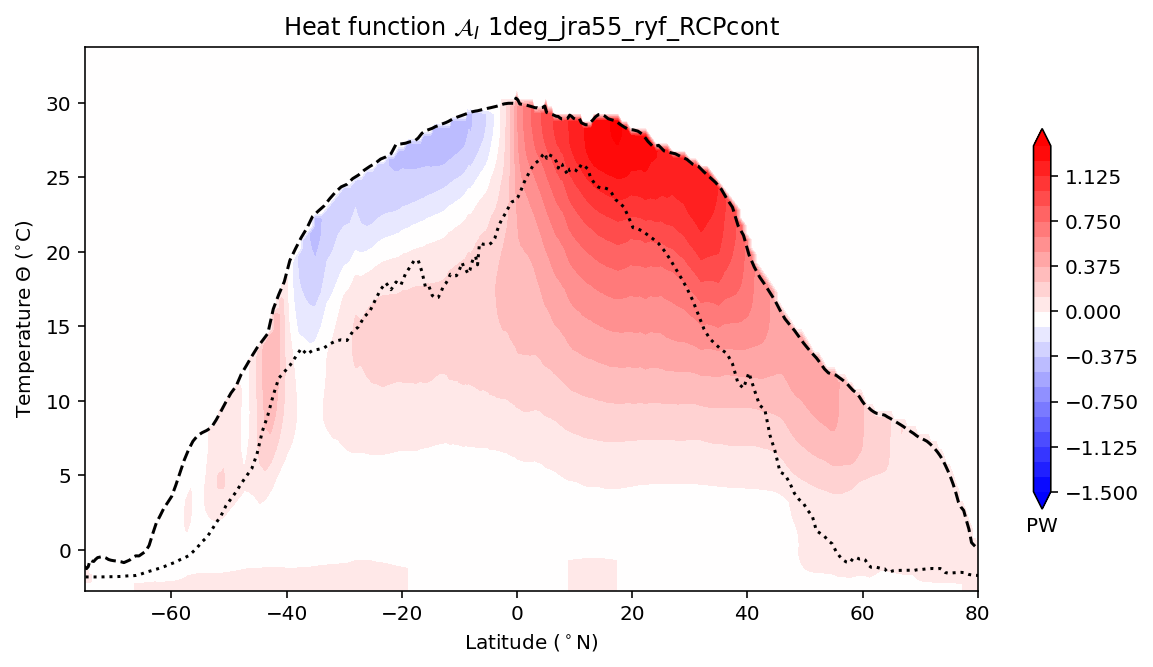

In [219]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-1.5,1.5,0.125)
plt.contourf(A_I.grid_yu_ocean,A_I.neutral, A_I, cmap='bwr', levels=clev, extend='both')
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-1.5,1.5,0.25)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

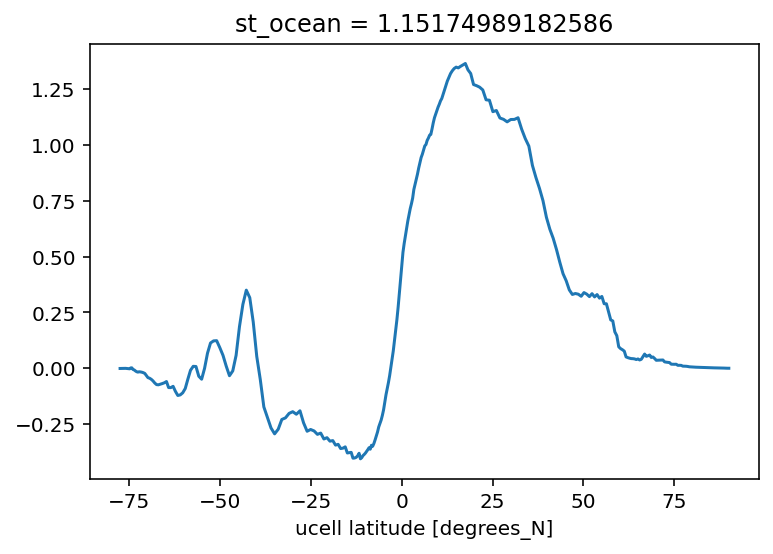

In [193]:
A_I_m = A_I.where(A_I.neutral > SST_mean-0.25).where(A_I.neutral < SST_mean+0.25).mean('neutral').plot()#.fillna(0)